# Diving with Titanic: Using Neural Networks, XGBoost and Random Forests

I tried to explore certain features of titanic dataset. Applied and tuned some of the most common used algorithms these days to get the results. Without further intreptions lets start by importing the right libraries

In [8]:
import pandas as pd
import numpy as np

In [10]:
import os

'/kaggle/working'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from plotly import __version__
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
import cufflinks as cf

In [ ]:
init_notebook_mode(connected=True)

In [ ]:
cf.go_offline()

In [4]:
import re

In [5]:
%matplotlib inline

# Importing Datasets

After importing the right libraries its time to import the dataset. As mentioned in description test data don't have survived column in it. So i decided to perform initial analysis by breaking training data to test and train set. We get to that step later. First lets import the dataset.

In [12]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

# Getting Familiar with the dataset

First just explore the dataset a bit more to get an understanding of whats happening.

In [13]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Info column tell us there are null columns in age, Cabin and Embarked. We need to figure out to deal with them.

In [16]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Initial Visualisations

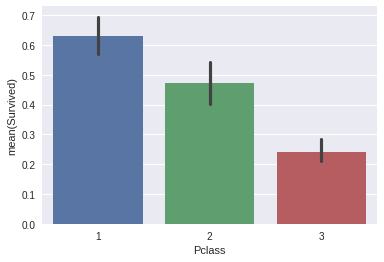

In [17]:
sns.barplot(x = 'Pclass', y = 'Survived', data = df_train )

As every department of life we have to figure out that class do matter. Here also the survival is highly based on class. Thats actually not surprising finding but an interesting one. 

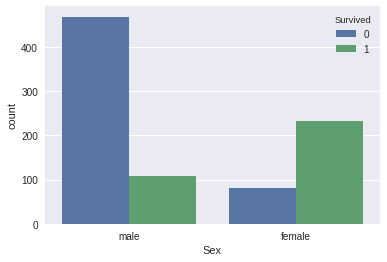

In [18]:
sns.countplot(x='Sex', hue = 'Survived',data=df_train)

This shows the respect of our society. Number of women survivors are more than men. Not surprising. 

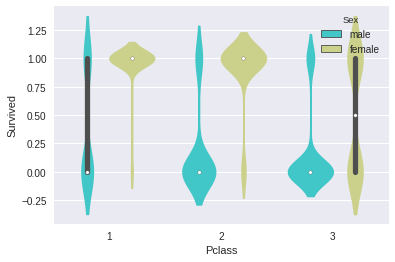

In [19]:
sns.violinplot(x="Pclass", y="Survived",hue ="Sex" ,data=df_train,palette='rainbow')

This graph shows 2 sides of our society. On the first hand it shows the respect we have for women. On the other hand it shows that women from lower class were not given equal chance as for women in upper classes. For us it makes job easier to understand the data.

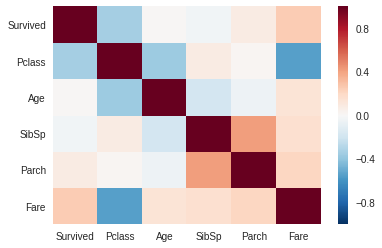

In [20]:
sns.heatmap(df_train.drop(['PassengerId', 'Name'], axis =1).fillna(0).corr())

The most important take aways in this chart are Survival is Corelated to Fare and Parch. We will dig more in this later in this kernel.

# Feature Engineering

Most of the feature engineering ideas have been taken from <a href="https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/">link.</a> With some of twists and turns. First converting textual labels to integer. I know this step can be done through LabelEncoder class of sckit learn. But i just did it myself anyway as it was simple and i am lazy to make objects :P. First lets do the trick with Sex Column.

In [21]:
df_train['Sex'] = df_train['Sex'].apply(lambda x: 1 if x == 'male' else 2)

In [22]:
df_test['Sex'] = df_test['Sex'].apply(lambda x: 1 if x == 'male' else 2)

Just parsing the name column will give us the Title of the person.

In [23]:
df_train['Salutation'] = df_train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [24]:
df_test['Salutation'] = df_test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [25]:
df_train['Salutation'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [26]:
def replace_titles(x):
    title=x['Salutation']
    
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Mr', 'Master', 'Sir']:
        return 1
    elif title in ['the Countess', 'Mme', 'Mrs', 'Lady']:
        return 2
    elif title in ['Mlle', 'Ms', 'Miss']:
        return 3
    elif title =='Dr':
        if x['Sex']=='Male':
            return 1
        else:
            return 2
    else:
        return title

I started with using the above function but after visualising the results. I found out that categorizing in 3 categories is not good idea. The titles obviously telling the class of the person and we know how that is highly corelated to outcome. So i decided to give a rank to each unique Title.

In [27]:
salutation = {'Don':1, 'Major':2, 'Capt':3, 'Jonkheer':4, 
              'Rev':5, 'Col':6, 'Mr':7, 'Master':8, 'Sir':9,
              'the Countess':10, 'Mme':11, 'Mrs':12, 'Lady':13,
              'Mlle':14, 'Ms':15, 'Miss':16,'Dr':17, 'Dona':1}

In [28]:
df_train['Salutation'] = df_train['Salutation'].apply(lambda x:salutation[x] )

In [29]:
df_test['Salutation'] = df_test['Salutation'].apply(lambda x:salutation[x] )

In [30]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [31]:
embarked = {'S':1,'C':2, 'Q':3}

In [32]:
df_train['Embarked'] = df_train['Embarked'].apply(lambda x: embarked[x] if x in embarked else x)

In [33]:
df_test['Embarked'] = df_test['Embarked'].apply(lambda x: embarked[x] if x in embarked else x)

Cabin might be the most controversial column. Most of the people like to drop it. We will just keep it for a while and see if we can do something more useful with this column. In the spirit of keeping data lets add another column to count the total number of cabins this person has booked. Well in order to map original cabin we need to know full map of titanic and some deeper information so lets follow <a href="https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/"> this article</a> once more. Instead of cabin let use the floor cabin is situated.

In [34]:
df_train['CabinCount'] = df_train['Cabin'].apply(lambda x: x if type(x) is float else len(x.split()))

In [35]:
df_test['CabinCount'] = df_test['Cabin'].apply(lambda x: x if type(x) is float else len(x.split()))

In [36]:
df_train['Cabin'] = df_train['Cabin'].apply(lambda x: x if type(x) is float else re.split('(\d+)',x)[0])

In [37]:
df_test['Cabin'] = df_test['Cabin'].apply(lambda x: x if type(x) is float else re.split('(\d+)',x)[0])

In [38]:
df_train['Cabin'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'F G', 'F E', 'T'], dtype=object)

In [39]:
cabins = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':8,'F G':6, 'F E':6}

In [40]:
df_train['Cabin'] = df_train['Cabin'].apply(lambda x: cabins[x] if x in cabins else x)

In [41]:
df_test['Cabin'] = df_test['Cabin'].apply(lambda x: cabins[x] if x in cabins else x)

In [42]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,CabinCount
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1.0,7,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,3.0,2.0,12,1.0
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0,16,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,3.0,1.0,12,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1.0,7,NaN


For starter just fill the NaN values to zero. So we can feed it to some model.

In [43]:
df_train.fillna(0 , inplace=True)

In [44]:
df_test.fillna(0 , inplace=True)

Well if we want to predict the floor of each user and we don't know the result sounds like we have a problem with in the problem. This is unsupervised learning problem we need to start first. I choose hirerical clustering. Lets draw the dendogram and see the number of clusters we got.

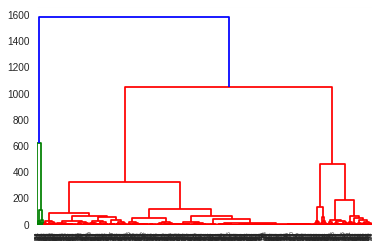

In [45]:
import scipy.cluster.hierarchy as sch
dendogram = sch.dendrogram(sch.linkage(df_train.drop(['Name','Ticket','Age', 'Embarked', 'Survived', 'Cabin', 'CabinCount', 'PassengerId'],axis=1), method='ward'))

I am always unclear about dendograms how to figure out appropriate number of clusters. Plus i think its very hard in dendogram to get odd numbers of clusters. This dendogram shows we have 4 clusters but lets confirm this with Elbow method borrowed from kmeans clustering.

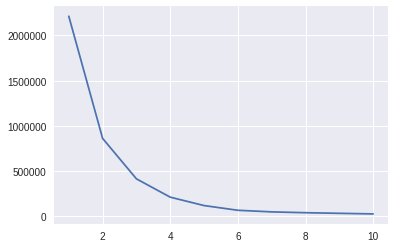

In [46]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_train.drop(['Name','Ticket','Age', 'Embarked', 'Survived', 'Cabin', 'CabinCount', 'PassengerId'],axis=1))
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.show()


I think dendogram was right about numbers of clusters available. Lets just create 4 clusters.

# Clustering for feature extraction

For now lets just apply the clustering on test and training sets by droping the columns that we need to fill yet.

In [47]:
from sklearn.cluster import AgglomerativeClustering
agc = AgglomerativeClustering(n_clusters=4)
df_train['Cluster'] = agc.fit_predict(df_train.drop(['Name','Ticket','Age', 'Embarked', 'Survived', 'Cabin', 'CabinCount', 'PassengerId'],axis=1))

In [48]:
df_test['Cluster'] = agc.fit_predict(df_test.drop(['Name','Ticket','Age', 'Embarked', 'Cabin', 'CabinCount', 'PassengerId'],axis=1))

In [49]:
df_groupby = df_train.groupby(by=df_train['Cluster']).count()

In [50]:
df_groupby_test = df_test.groupby(by=df_train['Cluster']).count()

In [51]:
df_groupby.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,CabinCount,Cluster
Cluster,,,,,,,,,,,,,,,
0,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151
1,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
2,720,720,720,720,720,720,720,720,720,720,720,720,720,720,720
3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


I was confused also there are three classes in the dataset but every method was telling 4 clusters. But last cluster got only three records. Lets move on to filling missing data. Lets take the mean of every column in each cluster.

In [52]:
df_groupby = df_train.groupby(by=df_train['Cluster']).mean()

In [53]:
df_groupby_test = df_test.groupby(by=df_train['Cluster']).mean()

In [54]:
df_groupby.reset_index(inplace=True)

In [55]:
#df_groupby_test.reset_index(inplace=True)

In [56]:
df_groupby_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Salutation,CabinCount,Cluster
Cluster,,,,,,,,,,,,
0,1112.191781,2.273973,1.342466,25.611781,0.342466,0.328767,36.177111,0.424658,1.356164,9.506849,0.178082,1.068493
1,1134.625000,2.625000,1.125000,20.312500,0.000000,0.000000,16.515637,0.375000,1.875000,8.000000,0.125000,1.125000
2,1097.000000,2.255952,1.372024,23.807560,0.482143,0.416667,35.924058,0.791667,1.479167,9.645833,0.309524,1.107143
3,1150.000000,2.000000,2.000000,19.000000,0.000000,0.000000,13.000000,0.000000,1.000000,16.000000,0.000000,1.000000


Lets make a simple function first to fill the mean of the corresponding cluster data to that specific user.

In [57]:
def fill_missing(x):
    
    if x['Cabin'] == 0.0:
        x['Cabin'] = float(round(df_groupby[df_groupby['Cluster'] == x['Cluster']]['Cabin']))
    if x['Age'] == 0.0:
        x['Age'] = float(round(df_groupby[df_groupby['Cluster'] == x['Cluster']]['Age']))
    if x['CabinCount'] == 0.0:
        x['CabinCount'] = float(round(df_groupby[df_groupby['Cluster'] == x['Cluster']]['CabinCount']))
    if x['Embarked'] == 0.0:
        x['Embarked'] = float(round(df_groupby[df_groupby['Cluster'] == x['Cluster']]['Embarked']))
    return x

In [58]:
df_train = df_train.apply(fill_missing, axis=1)

In [59]:
df_test = df_test.apply(fill_missing, axis=1)

In [60]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,CabinCount,Cluster
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0.0,1.0,7,0.0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,3.0,2.0,12,1.0,0
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,0.0,1.0,16,0.0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,3.0,1.0,12,1.0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0.0,1.0,7,0.0,2


Now we have no missing data. But lets see how our clustering did for the Cabin count. There were total 840 rooms in the titanic and we got 917 well thats not bad. Infact in 840 there were any for the crew that i don't know.

In [61]:
df_train['CabinCount'].value_counts()

0.0    640
1.0    225
2.0     18
3.0      6
4.0      2
Name: CabinCount, dtype: int64

In [62]:
df_train.groupby(by = df_train['Pclass']).sum()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Salutation,CabinCount,Cluster
Pclass,,,,,,,,,,,,
1,99705,136,310,7869.42,90,77,18177.4125,574.0,305.0,2193,228.0,170
2,82056,87,260,5410.83,74,70,3801.8417,98.0,207.0,1824,23.0,354
3,215625,119,635,11996.92,302,193,6714.6951,113.0,701.0,4593,36.0,942


In earlier analysis age is not a strong corelation with survival. But somehow it should be dependent on survival in my understanding because when people are saving young ladies they should put some thoughts for kids also. Thats why i divided the age in age groups to get something out of it.

In [63]:
df_train['Age'].min()

0.41999999999999998

In [64]:
df_train['Age'].max()

80.0

In [65]:
def assing_age_group(x):
    if x < 10:
        return 1
    elif x >= 10 and x < 18:
        return 2
    elif x >= 18 and x <25:
        return 3
    elif x >= 25 and x < 30:
        return 4
    elif x >= 30 and x < 40:
        return 5
    elif x >= 40 and x < 50:
        return 6
    elif x >= 50 and x < 60:
        return 7
    elif x >= 60:
        return 8

In [66]:
df_train['AgeGroup'] = df_train['Age'].apply(assing_age_group)

In [67]:
df_test['AgeGroup'] = df_test['Age'].apply(assing_age_group)

Lets just visualise what we have done so far and how it effects the data.

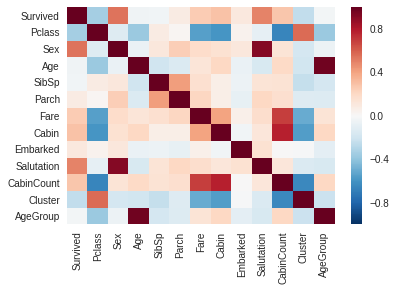

In [68]:
sns.heatmap(df_train.drop(['PassengerId', 'Name', 'Ticket'], axis =1).fillna(0).corr())

Well age group still not showing anything but CabinCount and survival are showing some signs. In the meantime Parch looks important in terms of survival. Lets just apply the feature engineering <a href="https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/"> from this link again.</a>

In [69]:
df_train['Family_Size']=df_train['SibSp']+df_train['Parch']

In [70]:
df_test['Family_Size']=df_test['SibSp']+df_test['Parch']

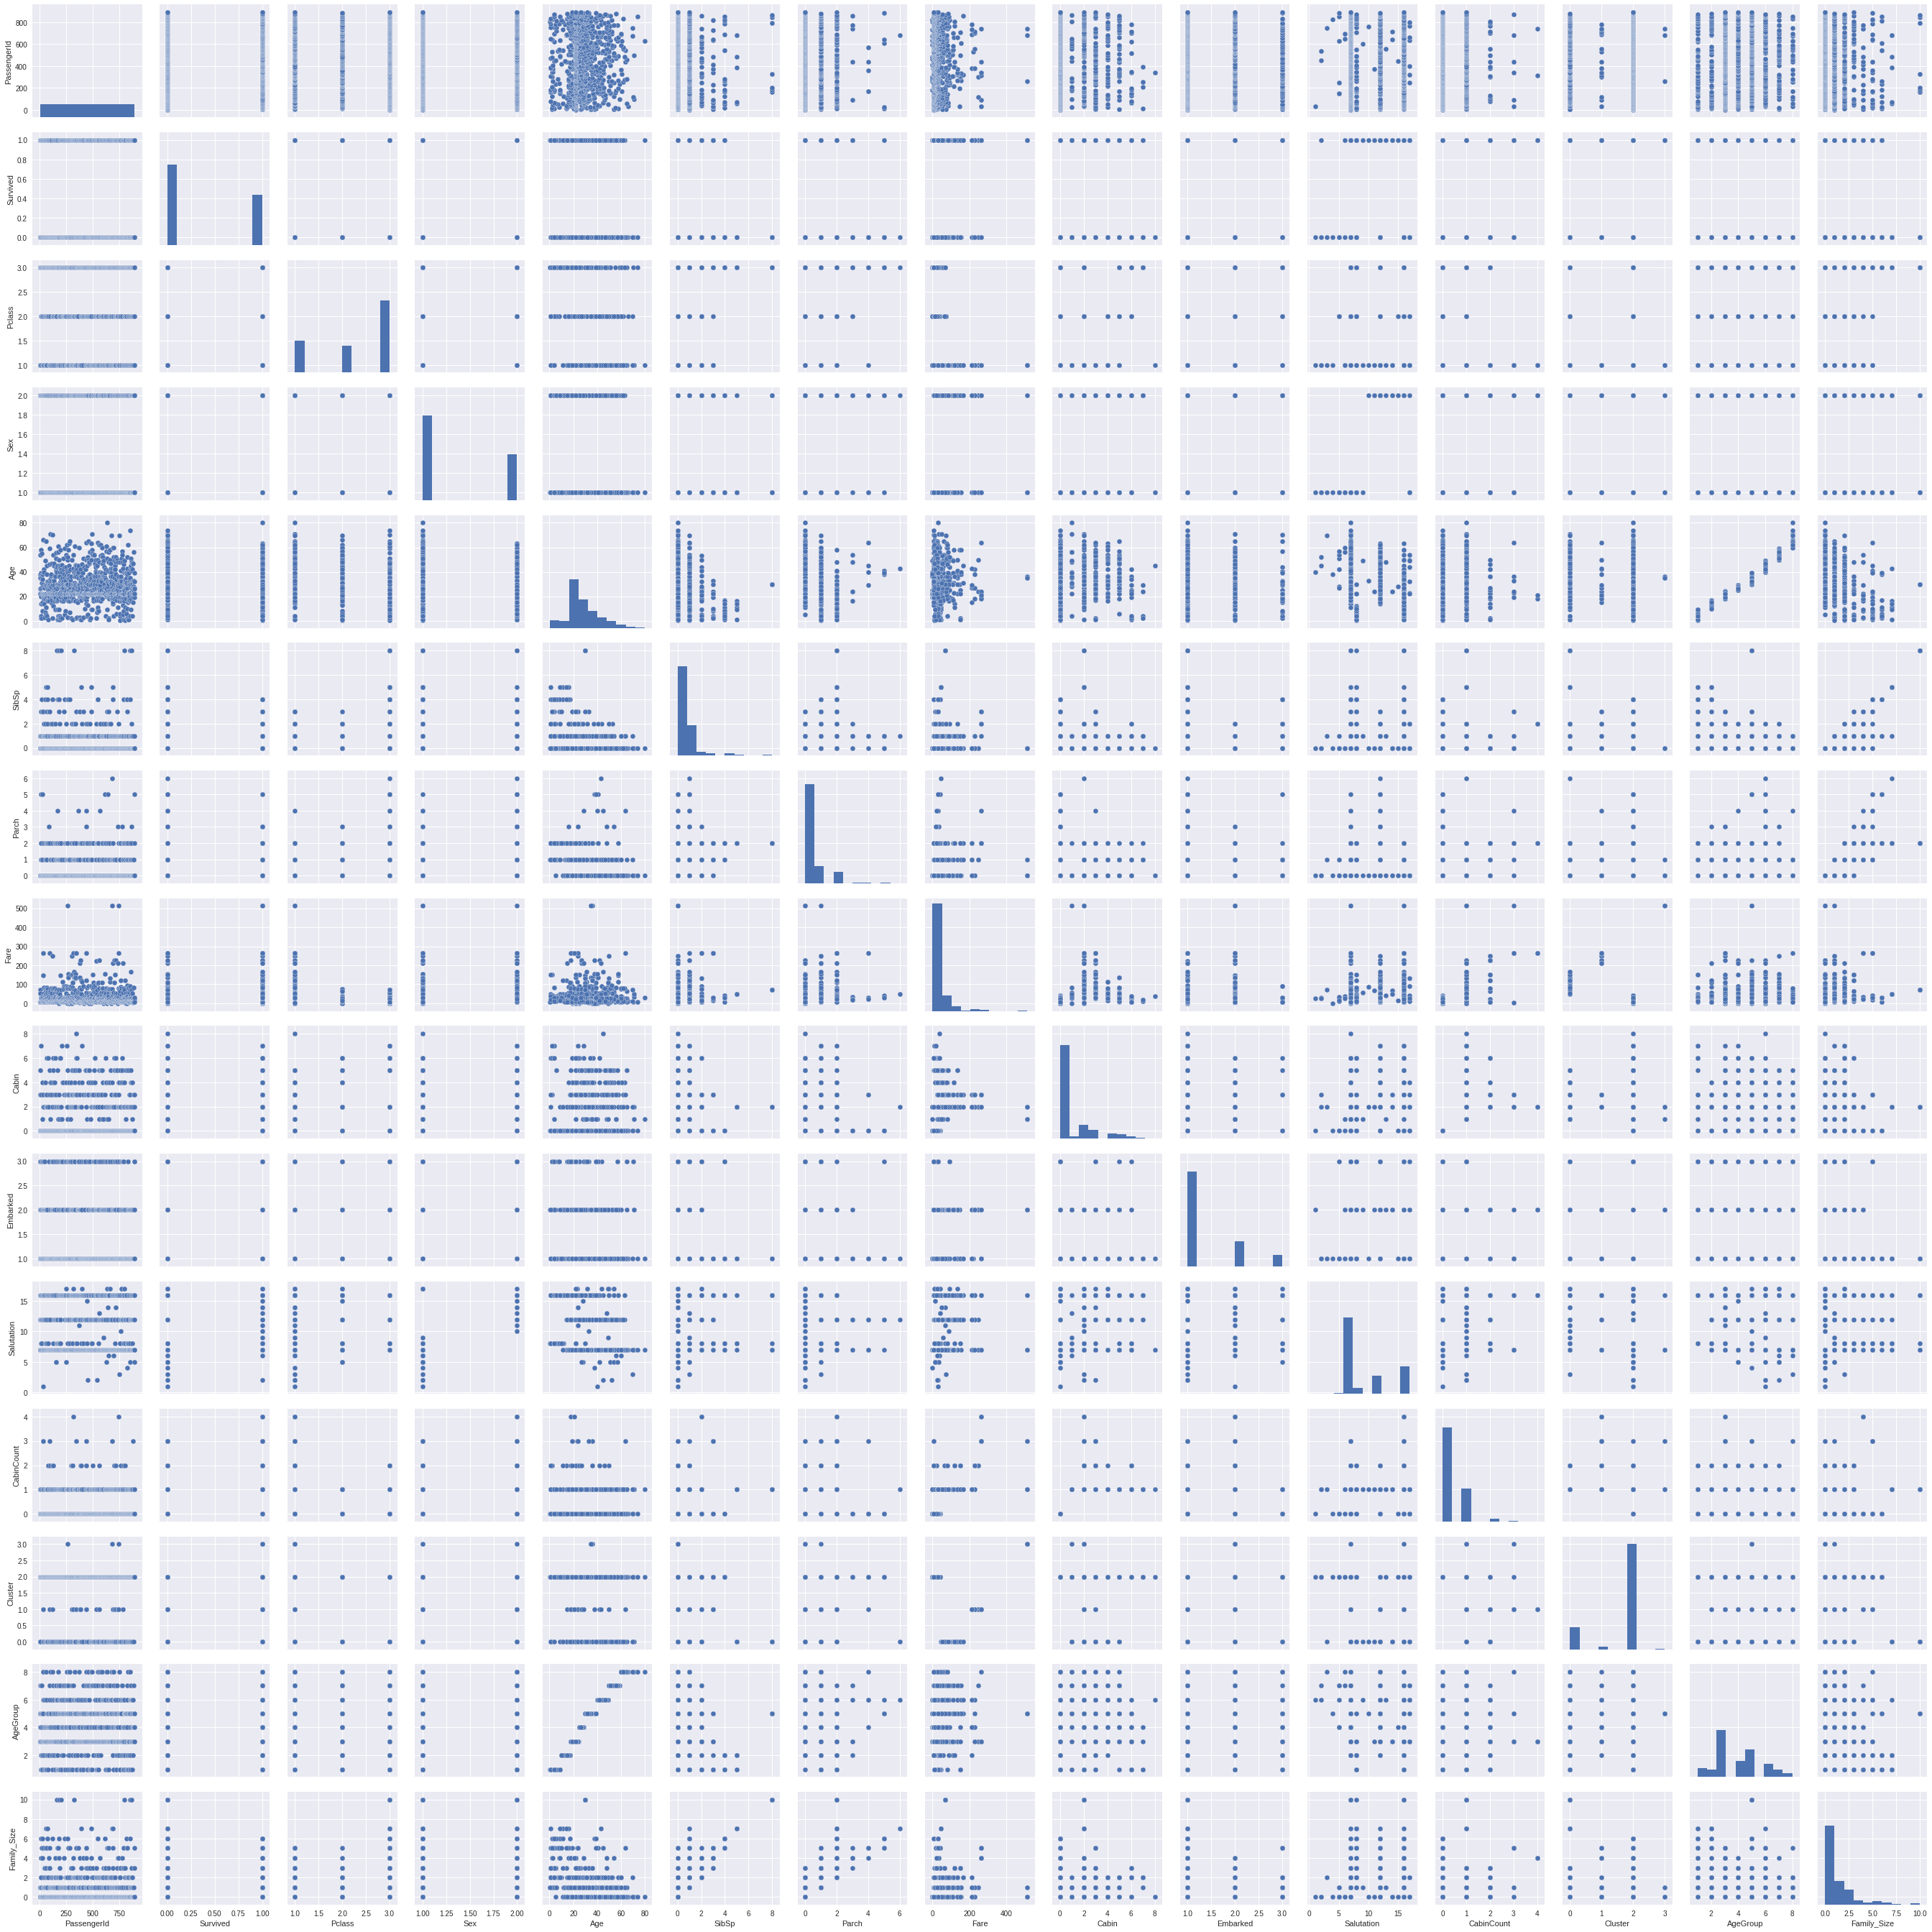

In [71]:
sns.pairplot(df_train)

In [72]:
df_train['Fare_Per_Person']=df_train['Fare']/(df_train['Family_Size']+1)

In [73]:
df_test['Fare_Per_Person']=df_test['Fare']/(df_train['Family_Size']+1)

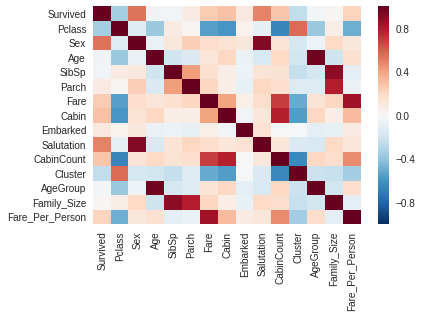

In [74]:
sns.heatmap(df_train.drop(['PassengerId', 'Name', 'Ticket'], axis =1).fillna(0).corr())

We reached to the end of our feature engineering. Now we need to get rid of columns which are not in use anymore. I am removing the cluster column also because i don't want to confuse the algorithm.

In [75]:
df_train.drop(['Ticket','Name', 'Cluster', 'Age'], inplace=True, axis = 1)
df_train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Salutation,CabinCount,AgeGroup,Family_Size,Fare_Per_Person
0,1,0,3,1,1,0,7.2500,0.0,1.0,7,0.0,3,1,3.62500
1,2,1,1,2,1,0,71.2833,3.0,2.0,12,1.0,5,1,35.64165
2,3,1,3,2,0,0,7.9250,0.0,1.0,16,0.0,4,0,7.92500
3,4,1,1,2,1,0,53.1000,3.0,1.0,12,1.0,5,1,26.55000
4,5,0,3,1,0,0,8.0500,0.0,1.0,7,0.0,5,0,8.05000


In [76]:
df_test.drop(['Ticket','Name', 'Cluster', 'Age'], inplace=True, axis = 1)
df_test.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Salutation,CabinCount,AgeGroup,Family_Size,Fare_Per_Person
0,892,3,1,0,0,7.8292,2.0,3,7,2.0,5,0,3.91460
1,893,3,2,1,0,7.0000,2.0,1,12,2.0,6,1,3.50000
2,894,2,1,0,0,9.6875,2.0,3,7,2.0,8,0,9.68750
3,895,3,1,0,0,8.6625,2.0,1,7,2.0,4,0,4.33125
4,896,3,2,1,1,12.2875,2.0,1,12,2.0,3,2,12.28750


In [77]:
X = df_train.iloc[:, 2:14].values
y = df_train.iloc[:, 1].values

In [78]:
X_main_test =  df_test.iloc[:, 1:13].values

With class column that is so important lets encode it.

In [79]:
from sklearn.preprocessing import OneHotEncoder

In [80]:
classhotEncoder = OneHotEncoder(categorical_features=[0])
X = classhotEncoder.fit_transform(X).toarray()

Important step to get rid of dummy variable trap.

In [81]:
X = X[:,1:]

In [82]:
classhotEncoder = OneHotEncoder(categorical_features=[0])
X_main_test = classhotEncoder.fit_transform(X_main_test).toarray()

In [83]:
X_main_test = X_main_test[:,1:]

As stated earlier we have to train our models with training set. So lets split the data to start applying models.

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Some algorithms required the features to be scaled while for others it won't hurt us. So lets perform this step.

In [85]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [86]:
sc = StandardScaler()
X = sc.fit_transform(X)
X_main_test = sc.fit_transform(X_main_test)

In [87]:
accuracy_results = pd.DataFrame(columns=['Algorithm','Results'])

# Logistic Regression

I will move step by step towards more commonly used algorithms, so starting with logistic regression.

In [88]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [89]:
y_pred = classifier.predict(X_test)

In [90]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score
cm = confusion_matrix(y_test, y_pred)

In [91]:
accuracy_results = accuracy_results.append(pd.DataFrame({'Algorithm':['Logistic_Regression'],'Results':[accuracy_score(y_test, y_pred)]}))

In [92]:
print(cm)
print('\n')
print(classification_report(y_test,y_pred.round()))

[[98 21]
 [17 43]]


             precision    recall  f1-score   support

          0       0.85      0.82      0.84       119
          1       0.67      0.72      0.69        60

avg / total       0.79      0.79      0.79       179



With all the hype for XGBoost and neural network. Logistic regression didn't perform that bad also.

# Support Vector Machines

There was no need to perform this algorithm but as i was moving slowly lets just do this step.

In [93]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [94]:
y_pred = classifier.predict(X_test)

In [95]:
cm = confusion_matrix(y_test, y_pred)

In [96]:
accuracy_results = accuracy_results.append(pd.DataFrame({'Algorithm':['SVC'],'Results':[accuracy_score(y_test, y_pred)]}))

In [97]:
print(cm)
print('\n')
print(classification_report(y_test,y_pred.round()))

[[101  18]
 [ 21  39]]


             precision    recall  f1-score   support

          0       0.83      0.85      0.84       119
          1       0.68      0.65      0.67        60

avg / total       0.78      0.78      0.78       179



Almost got rid of this algorithm but as we know there are certain problems where SVM performs really well. This might not be one of those problems but results are still not bad.

# Kernel SVM

When SVM performed good i had to apply this algorithm also.

In [98]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [99]:
y_pred = classifier.predict(X_test)

In [100]:
cm = confusion_matrix(y_test, y_pred)

In [101]:
accuracy_results = accuracy_results.append(pd.DataFrame({'Algorithm':['Kernel_SVM'],'Results':[accuracy_score(y_test, y_pred)]}))

In [102]:
print(cm)
print('\n')
print(classification_report(y_test,y_pred.round()))

[[104  15]
 [ 23  37]]


             precision    recall  f1-score   support

          0       0.82      0.87      0.85       119
          1       0.71      0.62      0.66        60

avg / total       0.78      0.79      0.78       179



Ok almost same and not too bad.

# Naive Bayes

Well this might not problem for naive bayes but i wanted to prove it to myself.

In [103]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None)

In [104]:
y_pred = classifier.predict(X_test)

In [105]:
cm = confusion_matrix(y_test, y_pred)

In [106]:
accuracy_results = accuracy_results.append(pd.DataFrame({'Algorithm':['Naive_Bayes'],'Results':[accuracy_score(y_test, y_pred)]}))

In [107]:
print(cm)
print('\n')
print(classification_report(y_test,y_pred.round()))

[[96 23]
 [17 43]]


             precision    recall  f1-score   support

          0       0.85      0.81      0.83       119
          1       0.65      0.72      0.68        60

avg / total       0.78      0.78      0.78       179



Ok so now thats proved lets move on to algorithms we want to use.

# Random Forest

In [108]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100,criterion='gini')
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [109]:
y_pred = classifier.predict(X_test)

In [110]:
cm = confusion_matrix(y_test, y_pred)

In [111]:
accuracy_results = accuracy_results.append(pd.DataFrame({'Algorithm':['Random_Forest'],'Results':[accuracy_score(y_test, y_pred)]}))

In [112]:
print(cm)
print('\n')
print(classification_report(y_test,y_pred.round()))

[[99 20]
 [16 44]]


             precision    recall  f1-score   support

          0       0.86      0.83      0.85       119
          1       0.69      0.73      0.71        60

avg / total       0.80      0.80      0.80       179



As expected random forest perform well but we need tune it. We will do it later.

# ANN

They say neural networks are powerful. Well they say so many things.

In [133]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# Dropout to avoid overfitting

In [131]:
from keras.layers import Dropout

In [132]:
classifier = Sequential()

In [134]:
classifier.add(Dense(activation="relu", input_dim=13, units=7, kernel_initializer="uniform"))

In [135]:
classifier.add(Dropout(rate=0.03))

/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()



In [136]:
classifier.add(Dense(activation="relu", units=7, kernel_initializer="uniform"))

In [137]:
classifier.add(Dropout(rate=0.03))

/opt/conda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()



In [138]:
classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="uniform"))

In [139]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [140]:
classifier.fit(X_train, y_train.reshape(-1,1), batch_size = 10, epochs = 300)

Epoch 1/300
712/712 [==============================] - 0s - loss: 0.6873 - acc: 0.6025     
Epoch 2/300
712/712 [==============================] - 0s - loss: 0.6326 - acc: 0.6110     
Epoch 3/300
712/712 [==============================] - 0s - loss: 0.5513 - acc: 0.7683     
Epoch 4/300
712/712 [==============================] - 0s - loss: 0.5104 - acc: 0.7978     
Epoch 5/300
712/712 [==============================] - 0s - loss: 0.4811 - acc: 0.7949     
Epoch 6/300
712/712 [==============================] - 0s - loss: 0.4592 - acc: 0.8006     
Epoch 7/300
712/712 [==============================] - 0s - loss: 0.4515 - acc: 0.8006     
Epoch 8/300
712/712 [==============================] - 0s - loss: 0.4361 - acc: 0.8076     
Epoch 9/300
712/712 [==============================] - 0s - loss: 0.4332 - acc: 0.8062     
Epoch 10/300
712/712 [==============================] - 0s - loss: 0.4314 - acc: 0.8048     
Epoch 11/300
712/712 [==============================] - 0s - loss: 0.4249 - acc

712/712 [==============================] - 0s - loss: 0.3787 - acc: 0.8301     
Epoch 89/300
712/712 [==============================] - 0s - loss: 0.3844 - acc: 0.8343     
Epoch 90/300
712/712 [==============================] - 0s - loss: 0.3875 - acc: 0.8315     
Epoch 91/300
712/712 [==============================] - 0s - loss: 0.3960 - acc: 0.8329     
Epoch 92/300
712/712 [==============================] - 0s - loss: 0.3936 - acc: 0.8287     
Epoch 93/300
712/712 [==============================] - 0s - loss: 0.3889 - acc: 0.8258     
Epoch 94/300
712/712 [==============================] - 0s - loss: 0.3847 - acc: 0.8272     
Epoch 95/300
712/712 [==============================] - 0s - loss: 0.3905 - acc: 0.8301     
Epoch 96/300
712/712 [==============================] - 0s - loss: 0.3875 - acc: 0.8301     
Epoch 97/300
712/712 [==============================] - 0s - loss: 0.3903 - acc: 0.8230     
Epoch 98/300
712/712 [==============================] - 0s - loss: 0.3832 - acc: 0.

712/712 [==============================] - 0s - loss: 0.3693 - acc: 0.8413     
Epoch 176/300
712/712 [==============================] - 0s - loss: 0.3707 - acc: 0.8399     
Epoch 177/300
712/712 [==============================] - 0s - loss: 0.3769 - acc: 0.8413     
Epoch 178/300
712/712 [==============================] - 0s - loss: 0.3723 - acc: 0.8441     
Epoch 179/300
712/712 [==============================] - 0s - loss: 0.3700 - acc: 0.8441     
Epoch 180/300
712/712 [==============================] - 0s - loss: 0.3673 - acc: 0.8413     
Epoch 181/300
712/712 [==============================] - 0s - loss: 0.3706 - acc: 0.8483     
Epoch 182/300
712/712 [==============================] - 0s - loss: 0.3728 - acc: 0.8427     
Epoch 183/300
712/712 [==============================] - 0s - loss: 0.3740 - acc: 0.8483     
Epoch 184/300
712/712 [==============================] - 0s - loss: 0.3722 - acc: 0.8413     
Epoch 185/300
712/712 [==============================] - 0s - loss: 0.3695

712/712 [==============================] - 0s - loss: 0.3540 - acc: 0.8624     
Epoch 262/300
712/712 [==============================] - 0s - loss: 0.3507 - acc: 0.8525     
Epoch 263/300
712/712 [==============================] - 0s - loss: 0.3669 - acc: 0.8497     
Epoch 264/300
712/712 [==============================] - 0s - loss: 0.3626 - acc: 0.8553     
Epoch 265/300
712/712 [==============================] - 0s - loss: 0.3602 - acc: 0.8525     
Epoch 266/300
712/712 [==============================] - 0s - loss: 0.3584 - acc: 0.8610     
Epoch 267/300
712/712 [==============================] - 0s - loss: 0.3670 - acc: 0.8567     
Epoch 268/300
712/712 [==============================] - 0s - loss: 0.3618 - acc: 0.8553     
Epoch 269/300
712/712 [==============================] - 0s - loss: 0.3615 - acc: 0.8497     
Epoch 270/300
712/712 [==============================] - 0s - loss: 0.3587 - acc: 0.8596     
Epoch 271/300
712/712 [==============================] - 0s - loss: 0.3541

In [141]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [142]:
accuracy_results = accuracy_results.append(pd.DataFrame({'Algorithm':['ANN'],'Results':[accuracy_score(y_test, y_pred)]}))

In [143]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('\n')
print(classification_report(y_test,y_pred.round()))

[[103  16]
 [ 18  42]]


             precision    recall  f1-score   support

          0       0.85      0.87      0.86       119
          1       0.72      0.70      0.71        60

avg / total       0.81      0.81      0.81       179



Ok, they might be correct. We will do parameter tunning for ANN later.

# XGBoost

Its time to check all the fuss about XGBoost

In [144]:
from xgboost import XGBClassifier
import xgboost as xgb
classifier = XGBClassifier(n_estimators=100)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [145]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('\n')
print(classification_report(y_test,y_pred.round()))

[[100  19]
 [ 16  44]]


             precision    recall  f1-score   support

          0       0.86      0.84      0.85       119
          1       0.70      0.73      0.72        60

avg / total       0.81      0.80      0.81       179



Results say everything. Probably NN were not properly trained but XGBoost outperformed them with a big margin in this case atleast.

In [146]:
accuracy_results = accuracy_results.append(pd.DataFrame({'Algorithm':['XGBoost'],'Results':[accuracy_score(y_test, y_pred)]}))

# Cross Validating XGBoost

Lets still do K Folds cross validation on XGBoost. 

In [148]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X, y = y, cv = 10)
accuracies.mean()

0.83168142095108377

It shows 83% accuracy which is not bad at all.

# Parameter Tuning

## Random Forest

The first step in tunning the models. We need to boost random forest.

In [149]:
from sklearn.model_selection import GridSearchCV

In [150]:
parameters = [{'n_estimators': [1, 10, 100, 1000], 'criterion': ['entropy', 'gini']}]

classifier = RandomForestClassifier(n_estimators=100,criterion='gini')
classifier.fit(X_train, y_train)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X, y)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print(best_accuracy)
print(best_parameters)

0.824915824916
{'criterion': 'entropy', 'n_estimators': 10}


## XGBoost

Most of the reading for parameter tuning has been done from this <a href="https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/"> link </a>.

In [151]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

A helper function taken from the <a href="https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/"> link </a>.

In [152]:
def modelfit(alg, xtrain, xtest, ytrain, ytest, predictors, cv_folds=5, early_stopping_rounds=50):
    
    alg.fit(xtrain, ytrain,eval_metric='auc')
        
    dtrain_predictions = alg.predict(xtest)
    dtrain_predprob = alg.predict_proba(xtest)[:,1]
        
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(ytest, dtrain_predictions))
    print (dtrain_predprob.shape)
    print ("AUC Score (Train): %f" % roc_auc_score(ytest, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Tunning child weights and depth

We fix the learning rate, child_weights and gamma. In the child weights a higher value is picked because as we see this is not imbalanced class problem.

In [153]:
predictors = [x for x in X]
xgb_child = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=7,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb_child, X_train, X_test, y_train, y_test.reshape(-1,1), predictors)

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.




Model Report
Accuracy : 0.8101
(179,)
AUC Score (Train): 0.854832


TypeError: 'str' object is not callable

Let perform Grid Search to find the optimal parameters for min_child_weight and max_depth

In [154]:
param_child = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch_child = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_child, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch_child.fit(X_train,y_train)
gsearch_child.cv_results_, gsearch_child.best_params_, gsearch_child.best_score_

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.



({'mean_fit_time': array([ 0.57858205,  0.32869372,  0.55114446,  0.76381645,  0.97067223,
          0.52310758,  1.25122194,  0.53884115,  0.54141693,  0.82297821,
          1.06312556,  0.79566302]),
  'mean_score_time': array([ 0.00609813,  0.00342355,  0.00263963,  0.00296316,  0.00523629,
          0.00622578,  0.01515489,  0.01019645,  0.0036973 ,  0.00252547,
          0.00738206,  0.00416446]),
  'mean_test_score': array([ 0.88464257,  0.88761293,  0.8880355 ,  0.8793601 ,  0.88903873,
          0.8877295 ,  0.87577483,  0.8833989 ,  0.88628912,  0.87430604,
          0.88452162,  0.88690403]),
  'mean_train_score': array([ 0.96319661,  0.95352241,  0.94702325,  0.98389407,  0.97014945,
          0.9575651 ,  0.99014912,  0.97454104,  0.95844414,  0.99179659,
          0.97478351,  0.95857426]),
  'param_max_depth': masked_array(data = [3 3 3 5 5 5 7 7 7 9 9 9],
               mask = [False False False False False False False False False False False False],
         fill_value 

Performing another grid search for optimal parameters

In [155]:
param_child_2 = {
 'max_depth':[3,4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch_child_2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_child_2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch_child_2.fit(X_train,y_train)
gsearch_child_2.cv_results_, gsearch_child_2.best_params_, gsearch_child_2.best_score_

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.



({'mean_fit_time': array([ 0.63014627,  0.5562367 ,  0.38998747,  0.58118215,  0.597086  ,
          0.49723468,  0.71869645,  0.62557535,  0.60195236,  0.99416032,
          1.28274293,  0.72717724]),
  'mean_score_time': array([ 0.00392942,  0.00231619,  0.0034224 ,  0.00464983,  0.01071701,
          0.00168304,  0.00702548,  0.00393987,  0.00264592,  0.00313134,
          0.00663314,  0.0020082 ]),
  'mean_test_score': array([ 0.88763843,  0.8880355 ,  0.88720566,  0.88499956,  0.88753206,
          0.88614086,  0.88753861,  0.8877295 ,  0.88569352,  0.88696669,
          0.88690549,  0.88671424]),
  'mean_train_score': array([ 0.95014862,  0.94702325,  0.9434026 ,  0.95949554,  0.95461045,
          0.94938087,  0.96399007,  0.9575651 ,  0.95169706,  0.96583808,
          0.95840701,  0.95175629]),
  'param_max_depth': masked_array(data = [3 3 3 4 4 4 5 5 5 6 6 6],
               mask = [False False False False False False False False False False False False],
         fill_value 

Here max depth is optimized as 3

In [156]:
param_test2b = {
 'min_child_weight':[4,5,6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=3,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train,y_train)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Pleas

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

({'mean_fit_time': array([ 0.57955995,  0.40112653,  0.62331071,  0.59665947,  0.58488889,
          0.42171488]),
  'mean_score_time': array([ 0.03191104,  0.00173283,  0.00555167,  0.00622334,  0.00137219,
          0.00502486]),
  'mean_test_score': array([ 0.88763843,  0.8880355 ,  0.88720566,  0.8808635 ,  0.88011635,
          0.8799608 ]),
  'mean_train_score': array([ 0.95014862,  0.94702325,  0.9434026 ,  0.93555597,  0.92957478,
          0.9238004 ]),
  'param_min_child_weight': masked_array(data = [4 5 6 8 10 12],
               mask = [False False False False False False],
         fill_value = ?),
  'params': [{'min_child_weight': 4},
   {'min_child_weight': 5},
   {'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'rank_test_score': array([2, 1, 3, 4, 5, 6], dtype=int32),
  'split0_test_score': array([ 0.9377805 ,  0.94594043,  0.94104447,  0.9371685 ,  0.93390453,
          0.9371685 ]),
  'split0_train_scor

Lets do another final computation find max depth and optimal numbers of child weight

In [157]:
param_test2b = {
 'min_child_weight':[3,4,8,12,14,16],
 'max_depth':[2,3,4,5,6]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(X_train,y_train)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Pleas

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

({'mean_fit_time': array([ 0.457689  ,  0.46104074,  0.45890274,  0.43252907,  0.36143646,
          0.40571551,  0.37885094,  0.39454031,  0.39637737,  0.38930316,
          0.44274087,  0.5105195 ,  0.90437365,  0.48605046,  0.4915957 ,
          0.7659606 ,  0.58761253,  0.36557555,  0.64900074,  0.66747394,
          0.55808282,  0.63847728,  0.54819975,  0.47838306,  0.76447802,
          0.69204521,  0.75935249,  0.68709946,  0.52285748,  0.43430872]),
  'mean_score_time': array([ 0.00566912,  0.00355034,  0.00565186,  0.00311389,  0.0023221 ,
          0.00233345,  0.00346003,  0.01121597,  0.00154638,  0.01253853,
          0.01903887,  0.00286002,  0.00316768,  0.00419364,  0.00209093,
          0.00447392,  0.00773559,  0.00673847,  0.00280213,  0.00769014,
          0.00334363,  0.00253844,  0.01686559,  0.01747813,  0.0032362 ,
          0.00362597,  0.00393381,  0.0022696 ,  0.0020906 ,  0.00232582]),
  'mean_test_score': array([ 0.88385717,  0.88471324,  0.879151  ,  0.87

Optimal value for max_depth and min_child_weight is determined

### Tunning Gamma

In [158]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=12, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Pleas

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

({'mean_fit_time': array([ 0.6011867 ,  0.62535534,  0.36672144,  0.6696136 ,  0.2924016 ]),
  'mean_score_time': array([ 0.00805101,  0.00590105,  0.00206599,  0.00289488,  0.00427251]),
  'mean_test_score': array([ 0.8799608 ,  0.88045768,  0.87971673,  0.87954479,  0.88032946]),
  'mean_train_score': array([ 0.9238004 ,  0.92377363,  0.9236606 ,  0.92355333,  0.9233804 ]),
  'param_gamma': masked_array(data = [0.0 0.1 0.2 0.3 0.4],
               mask = [False False False False False],
         fill_value = ?),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([3, 1, 4, 5, 2], dtype=int32),
  'split0_test_score': array([ 0.9371685 ,  0.93818849,  0.9377805 ,  0.9371685 ,  0.93920849]),
  'split0_train_score': array([ 0.91619509,  0.91640181,  0.91653101,  0.91624031,  0.91614987]),
  'split1_test_score': array([ 0.87729498,  0.87668299,  0.875255  ,  0.87749898,  0.87668299]),
  'split1_train_score': 

Value of gamma seems to be zero. Lets test determined variables.

In [159]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=12,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, X_train, X_test, y_train, y_test, predictors)

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.




Model Report
Accuracy : 0.8436
(179,)
AUC Score (Train): 0.860294


TypeError: 'str' object is not callable

### Tune SUB Sample and ColSubSample

In [160]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=12, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.



({'mean_fit_time': array([ 0.38073745,  0.09019027,  0.6727787 ,  0.58489985,  0.78514614,
          0.83574505,  0.7911253 ,  0.85849528,  0.58577795,  0.51752338,
          0.46143174,  0.58655586,  0.60583172,  0.70677357,  0.49959722,
          0.4752008 ]),
  'mean_score_time': array([ 0.00449886,  0.00117426,  0.01437259,  0.01690159,  0.0023757 ,
          0.00481105,  0.00281534,  0.0055439 ,  0.00746365,  0.01170321,
          0.00906143,  0.0030478 ,  0.00181646,  0.00771737,  0.00194654,
          0.0043735 ]),
  'mean_test_score': array([ 0.86828372,  0.87680976,  0.88104345,  0.88308781,  0.86944104,
          0.87792301,  0.88179242,  0.88533543,  0.87012152,  0.87824576,
          0.88155345,  0.88396791,  0.87029857,  0.87718133,  0.88317523,
          0.88427464]),
  'mean_train_score': array([ 0.90666337,  0.91742545,  0.92442903,  0.9284243 ,  0.90821684,
          0.91906367,  0.92604189,  0.92993165,  0.90933261,  0.91995436,
          0.92724357,  0.9305416 ,  0.9

The best parameters for colsubsample and subsamples are found to be .9 and 0.8

### Tunning Regularization Parameters

In [161]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=3,
 min_child_weight=12, gamma=0.0, subsample=0.8, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,y_train)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

({'mean_fit_time': array([ 0.63043971,  0.57698059,  0.60082922,  0.62276959,  0.26336212]),
  'mean_score_time': array([ 0.00348768,  0.00230818,  0.00608096,  0.00389695,  0.00343642]),
  'mean_test_score': array([ 0.88317523,  0.88350236,  0.88247071,  0.88168386,  0.66355059]),
  'mean_train_score': array([ 0.92772857,  0.92808673,  0.92764109,  0.92371529,  0.67823222]),
  'param_reg_alpha': masked_array(data = [1e-05 0.01 0.1 1 100],
               mask = [False False False False False],
         fill_value = ?),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'rank_test_score': array([2, 1, 3, 4, 5], dtype=int32),
  'split0_test_score': array([ 0.94288046,  0.94451244,  0.94165647,  0.94165647,  0.82211342]),
  'split0_train_score': array([ 0.91949612,  0.9201938 ,  0.91900517,  0.91501938,  0.78467054]),
  'split1_test_score': array([ 0.87851897,  0.87831497,  0.87933497,  0.87872297,  0.5       ])

The CV scored have been same as previous values. So we need to tone the alpha.

In [162]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=300, max_depth=3,
 min_child_weight=12, gamma=0.0, subsample=0.8, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train, y_train)
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

({'mean_fit_time': array([ 0.94569263,  1.10130062,  0.9078711 ,  0.86772251,  0.6203649 ]),
  'mean_score_time': array([ 0.0087379 ,  0.00599899,  0.00550914,  0.00438681,  0.00403309]),
  'mean_test_score': array([ 0.88630734,  0.88626654,  0.88626217,  0.88729892,  0.88610043]),
  'mean_train_score': array([ 0.93662089,  0.93642711,  0.93649689,  0.93660276,  0.93627527]),
  'param_reg_alpha': masked_array(data = [0 0.001 0.005 0.01 0.05],
               mask = [False False False False False],
         fill_value = ?),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'rank_test_score': array([2, 3, 4, 1, 5], dtype=int32),
  'split0_test_score': array([ 0.94879641,  0.94859241,  0.94920441,  0.9498164 ,  0.94859241]),
  'split0_train_score': array([ 0.92849483,  0.92755168,  0.9277584 ,  0.92822351,  0.92774548]),
  'split1_test_score': array([ 0.87933497,  0.87933497,  0.87994696,  0.87974296,  0.8793

Now the CV score has improved. lets fit this into XGB and see the results.

In [163]:
xgb_final = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=12,
 gamma=0.0,
 reg_alpha = 0.001,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb_final, X_train, X_test, y_train, y_test.reshape(-1,1), predictors)

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:203: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/opt/conda/lib/python3.6/site-packages/xgboost-0.6-py3.6.egg/xgboost/sklearn.py:210: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.




Model Report
Accuracy : 0.838
(179,)
AUC Score (Train): 0.861625


TypeError: 'str' object is not callable

The accuracy has been improved.

## ANN

This step will take a while.

In [ ]:
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu', input_dim = 13))
    classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [ ]:
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32, 35, 40],
              'epochs': [100, 200, 500],
              'optimizer': ['adam', 'rmsprop']}

In [ ]:
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X, y)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [ ]:
print(best_accuracy)
print(best_parameters)

# Final model fitting with X and y, to predict on training set

## Random Forest

In [ ]:
df_results = pd.DataFrame()

In [ ]:
classifier = RandomForestClassifier(n_estimators=100,criterion='gini')
classifier.fit(X_train, y_train)
df_results['RandomForest'] = classifier.predict(X_test)

## XGBoost

In [ ]:
classifier = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=12,
 gamma=0.0,
 reg_alpha = 0.001,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
classifier.fit(X_train, y_train)
df_results['XGBoost'] = classifier.predict(X_test)

## ANN

In [ ]:
classifier = Sequential()
classifier.add(Dense(activation="relu", input_dim=13, units=7, kernel_initializer="uniform"))
classifier.add(Dropout(rate=0.03))
classifier.add(Dense(activation="relu", units=7, kernel_initializer="uniform"))
classifier.add(Dropout(rate=0.03))
classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="uniform"))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.fit(X_train, y_train.reshape(-1,1), batch_size = 25, epochs = 500)

In [ ]:
df_results['ANN'] = (classifier.predict(X_test) > 0.5)

# Combining model through voting

In [ ]:
df_results['Ensemble'] = (df_results.mean(axis=1) > 0.5)

In [ ]:
cm = confusion_matrix(y_test, df_results['Ensemble'])
print(cm)
print('\n')
print(classification_report(y_test,df_results['Ensemble']))

Lets Check another metrics

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test,df_results['Ensemble'])

As they say 2 is always better than one. So thats makes it simple.

## Fitting Models on complete training set and generating results

## Random Forest

In [ ]:
df_results = pd.DataFrame()

In [ ]:
classifier = RandomForestClassifier(n_estimators=100,criterion='gini')
classifier.fit(X, y)
df_results['RandomForest'] = classifier.predict(X_main_test)

## XGBoost

In [ ]:
classifier = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=12,
 gamma=0.0,
 reg_alpha = 0.001,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
classifier.fit(X, y)
df_results['XGBoost'] = classifier.predict(X_main_test)

## ANN

In [ ]:
classifier = Sequential()
classifier.add(Dense(activation="relu", input_dim=13, units=7, kernel_initializer="uniform"))
classifier.add(Dropout(rate=0.03))
classifier.add(Dense(activation="relu", units=7, kernel_initializer="uniform"))
classifier.add(Dropout(rate=0.03))
classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="uniform"))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
classifier.fit(X, y.reshape(-1,1), batch_size = 25, epochs = 500)

## Ensemble

In [ ]:
df_results['Ensemble'] = (df_results.mean(axis=1) > 0.5)

In [ ]:
df_test['Survived'] = df_results['Ensemble']

In [ ]:
df_test['Survived'] = df_test['Survived'].apply(lambda x: int(x))

In [ ]:
df_test.drop(['Pclass','Sex','Parch', 'SibSp', 'Fare', 'Cabin', 'Embarked', 'Salutation', 'CabinCount', 'AgeGroup','Family_Size','Fare_Per_Person'], axis =1, inplace=True)

In [ ]:
df_test.to_csv('test_results.csv', index=False)